In [2]:
#pip install xgboost

All transformations to the data were completed in earlier phases. 

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as mplt
import seaborn as sn
from scipy import stats

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , classification_report , f1_score

In [5]:
df = pd.read_csv('model_df.csv')

In [6]:
df.pop('Unnamed: 0')

0              0
1              1
2              2
3              3
4              4
           ...  
590532    590535
590533    590536
590534    590537
590535    590538
590536    590539
Name: Unnamed: 0, Length: 590537, dtype: int64

In [7]:
#df.describe()

In [8]:
df.shape

(590537, 228)

In [45]:
df['TransactionAmt'].mean()

135.02683800553552

In [9]:
df.groupby('isFraud').mean()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_32
isFraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.360770e+06,134.511311,9911.495462,362.455656,152.862941,199.540366,290.652886,86.812298,118.031805,13.31477,14.173135,0.005840,3.693897,5.722353,8.786277,2.517497,4.560905,4.580767,4.723551,9.747699,3.549720,32.813804,8.220331,96.360355,170.831524,...,20.595489,42.048203,25.734789,111.098356,243.810579,161.623347,18.368728,41.624742,28.204731,-10.053223,174188.719322,0.059296,-0.057431,1.618317,-6.669510,0.089859,-0.302362,99.744727,48.067263,-344.663060,189.150161,14.235634,353.516876,403.264110,26.501285
1,7.690033e+06,149.244779,9547.654164,365.313219,162.351333,192.068362,292.974830,86.478811,131.407103,35.53574,45.509413,0.000242,15.077336,1.406717,16.923148,11.977157,21.242608,1.703964,19.493926,23.857475,18.597541,24.967768,10.356047,38.835164,134.603591,...,42.204210,78.378166,56.381228,74.529997,352.313168,176.780111,18.478504,54.408351,31.691347,-13.404992,189274.817221,0.084820,-0.100502,1.540216,-7.504051,0.123137,-0.266961,99.761803,47.661651,-340.207138,197.758742,14.284308,342.408008,420.942111,26.710254


We can see that all 228 features are numerical. 

Now we will run logistic regression on a balanced dataset created from df using undersampling.

Undersampling idea:
1. We will separate the legitimate and fraudulent transactions into separate dataframes
2. A random sample of fraud.shape(axis=0) will be created using df.sample and concatenated with fraud dataframe
3. A number of different random samples will be created

In [10]:
# df's with only one label rows
legit = df[df.isFraud == 0]
fraud = df[df.isFraud == 1]

In [11]:
legit.shape

(569874, 228)

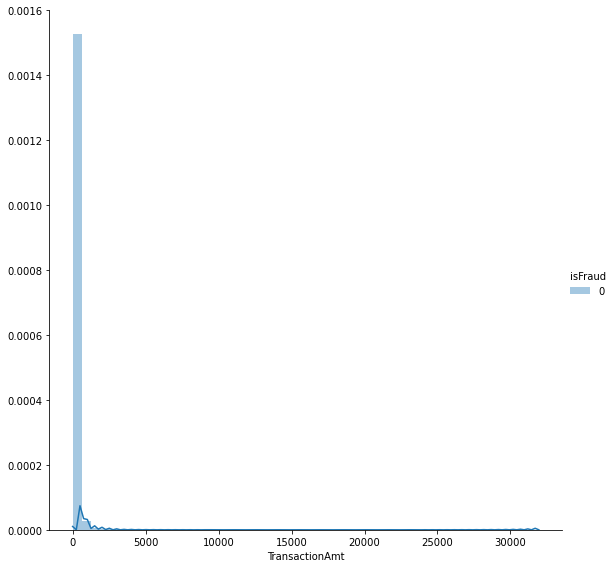

In [12]:
sn.FacetGrid(legit, hue='isFraud' , height=8) \
   .map(sn.distplot, "TransactionAmt") \
   .add_legend();
mplt.show();

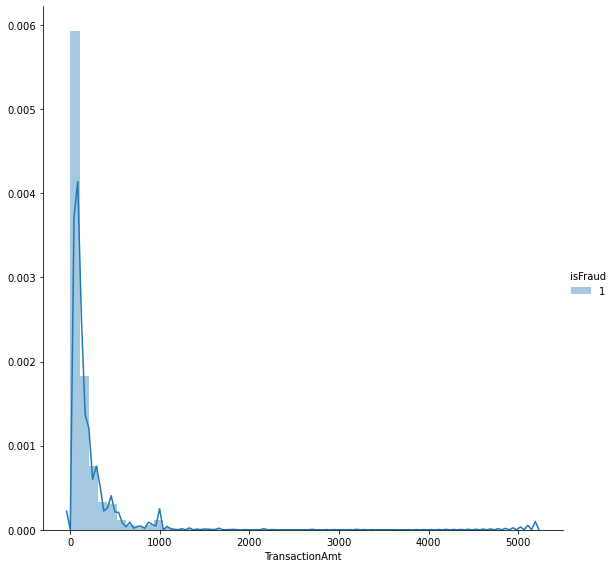

In [13]:
sn.FacetGrid(fraud, hue='isFraud' , height=8) \
   .map(sn.distplot, "TransactionAmt") \
   .add_legend();
mplt.show();

In [14]:
legit_sample = legit.sample(n=fraud.shape[0])

In [15]:
print(legit_sample.shape)
print(fraud.shape)

(20663, 228)
(20663, 228)


In [16]:
new_df = pd.concat([legit_sample, fraud], axis=0)
#new_df

In [17]:
new_df.shape

(41326, 228)

In [18]:
new_df.groupby('isFraud').mean()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_32
isFraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.350419e+06,132.642487,9978.001791,362.232199,152.912997,199.325414,290.476538,86.796997,115.767806,11.993854,12.770072,0.008760,2.975173,5.772782,8.122247,1.842182,3.513381,4.650874,3.698446,8.840778,2.606833,32.056236,7.796012,96.387394,170.448800,...,20.315387,41.404510,25.537324,107.909634,234.667252,158.845562,16.709534,39.397376,26.617559,-10.013798,173649.693845,0.061007,-0.057417,1.621034,-6.717657,0.089839,-0.305158,99.744136,48.055007,-344.251521,189.213538,14.232142,353.048992,403.360448,26.495023
1,7.690033e+06,149.244779,9547.654164,365.313219,162.351333,192.068362,292.974830,86.478811,131.407103,35.535740,45.509413,0.000242,15.077336,1.406717,16.923148,11.977157,21.242608,1.703964,19.493926,23.857475,18.597541,24.967768,10.356047,38.835164,134.603591,...,42.204210,78.378166,56.381228,74.529997,352.313168,176.780111,18.478504,54.408351,31.691347,-13.404992,189274.817221,0.084820,-0.100502,1.540216,-7.504051,0.123137,-0.266961,99.761803,47.661651,-340.207138,197.758742,14.284308,342.408008,420.942111,26.710254


After comparing means of class label 0 data points from the new sampled dataframe with the original dataframe, therefore the nature of the distributions for each class has not changed too much and we also have a balanced dataset

# 1. Split data into x and y
# 2. Standardize x

In [19]:
x = new_df.drop(columns=['isFraud'], axis=1)
y = new_df['isFraud']

In [20]:
#x.shape

In [21]:
standard = StandardScaler()
x_sc = standard.fit_transform(x)

In [46]:
#x_sc.shape

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x_sc,y,test_size=0.1,random_state=42,stratify=y)

In [24]:
y_train.value_counts()

1    18597
0    18596
Name: isFraud, dtype: int64

In [25]:
y_test.value_counts()

0    2067
1    2066
Name: isFraud, dtype: int64

# 3. Logistic Regression

In [26]:
model = LogisticRegression()
model.fit(x_train,y_train)

C:\Users\leobu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
y_pred = model.predict(x_test)

In [28]:
print("Train accuracy :", model.score(x_train,y_train))
print("Test accuracy :", model.score(x_test,y_test))

Train accuracy : 0.7562444546016723
Test accuracy : 0.7669973384950399


In [29]:
print(confusion_matrix(y_test,y_pred))

[[1666  401]
 [ 562 1504]]


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2067
           1       0.79      0.73      0.76      2066

    accuracy                           0.77      4133
   macro avg       0.77      0.77      0.77      4133
weighted avg       0.77      0.77      0.77      4133



# 4. Random Forest

In [31]:
model1 = RandomForestClassifier()
model1.fit(x_train, y_train)

RandomForestClassifier()

In [32]:
y_pred = model1.predict(x_test)

In [33]:
print("Training Accuracy :", model1.score(x_train, y_train))
print("Testing Accuracy :", model1.score(x_test, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.854827002177595


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2067
           1       0.88      0.82      0.85      2066

    accuracy                           0.85      4133
   macro avg       0.86      0.85      0.85      4133
weighted avg       0.86      0.85      0.85      4133



In [35]:
print("F1 Score:",f1_score(y_test, y_pred))

F1 Score: 0.8496993987975952


In [37]:
print(confusion_matrix(y_test,y_pred))

[[1837  230]
 [ 370 1696]]


# 5. XGBoost

In [38]:
model2 = XGBClassifier(n_jobs=-1)
model2.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [39]:
y_pred = model2.predict(x_test)

In [40]:
print("Training Accuracy :", model2.score(x_train, y_train))
print("Testing Accuracy :", model2.score(x_test, y_test))

Training Accuracy : 0.9093646653940257
Testing Accuracy : 0.8618436970723445


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2067
           1       0.89      0.82      0.86      2066

    accuracy                           0.86      4133
   macro avg       0.86      0.86      0.86      4133
weighted avg       0.86      0.86      0.86      4133



In [42]:
print("F1 Score:",f1_score(y_test, y_pred))

F1 Score: 0.8564244405330652


In [43]:
print(confusion_matrix(y_test,y_pred))

[[1859  208]
 [ 363 1703]]


# Sampled feature correlation

In [48]:
cor_matrix = new_df.corr()
print(cor_matrix)

                 isFraud  TransactionDT  TransactionAmt     card1     card2  \
isFraud         1.000000       0.037501        0.035744 -0.044427  0.009811   
TransactionDT   0.037501       1.000000        0.021074  0.018150 -0.006086   
TransactionAmt  0.035744       0.021074        1.000000  0.002551  0.043236   
card1          -0.044427       0.018150        0.002551  1.000000  0.002817   
card2           0.009811      -0.006086        0.043236  0.002817  1.000000   
...                  ...            ...             ...       ...       ...   
id_17           0.216569       0.075835       -0.168687 -0.006573 -0.067561   
id_18           0.048695       0.037098       -0.024508  0.007902 -0.021792   
id_19          -0.065368      -0.011257        0.038017  0.015893  0.010246   
id_20           0.097440       0.034216       -0.043490  0.005468 -0.004596   
id_32           0.068626      -0.039720        0.038863 -0.003881  0.007715   

                   card3     card5     addr1     ad